# Conceptual drawing for the polytope figure for NSF-AI whitepaper

1. simply showing a true posterior for XOR, and then that posterior but partitioned into 4 polytopes (and the magnitude per polytope is just the average over that space), and then another one for 64 polytopes.
2. given the polytopes (either 4 or 64), a plot of estimated Risk vs. sample size for XOR, XNOR, and RXOR.  i'm guessing the 64 will converge much slower than the 4 for XOR and XNOR, but for RXOR, it will converge to something with a far lower risk.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import random
from scipy.spatial import Voronoi, voronoi_plot_2d

from util import true_xor, generate_mask, generate_gaussian_parity
from util import generate_polytope, calculate_risks, voronoi_finite_polygons_2d

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
seed = 1234 #random seed
rng = 1 #data range
h = 0.04 #definition (affects number of sample)

## Generate True Posterior

In [3]:
# this takes too long to run
# trueXOR = true_xor(rng=rng, h=h, rotate=False, newpdf=True)

In [4]:
trueXOR_old = true_xor(rng=rng, h=h, rotate=False, newpdf=False)

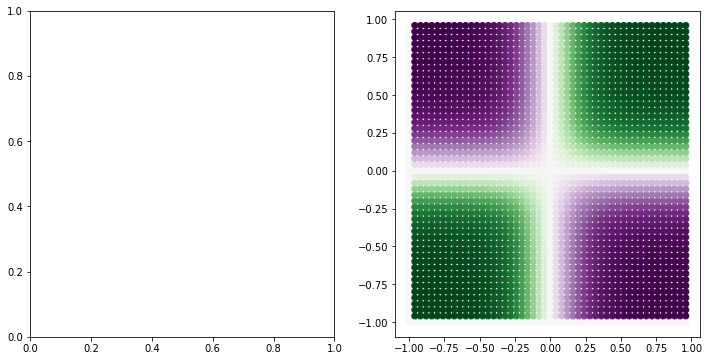

In [5]:
fig, ax = plt.subplots(1,2, figsize=(6*2,6))

# ax[0].scatter(trueXOR[0],trueXOR[1],c=trueXOR[2],cmap='PRGn')
ax[1].scatter(trueXOR_old[0],trueXOR_old[1],c=trueXOR_old[2],cmap='PRGn')

## Generate Posterior Image

#### Create a grid

In [6]:
grid = generate_mask(rng=rng, h=h)
N = grid.shape[0]
grid.shape

(2500, 2)

#### Train `RF` and `DN`

In [7]:
X, y = generate_gaussian_parity(n_samples=N)

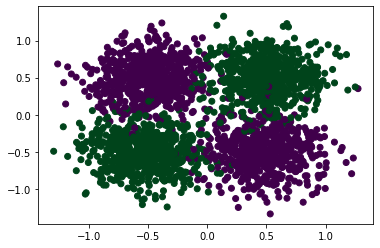

In [8]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='PRGn')

In [9]:
clf_rf = RandomForestClassifier()
clf_mlp = MLPClassifier()

In [10]:
clf_rf.fit(X,y)
clf_mlp.fit(X,y)

MLPClassifier()

In [12]:
pred_rf = clf_rf.predict_proba(grid)
pred_mlp = clf_mlp.predict_proba(grid)

#### Generate a posterior plot

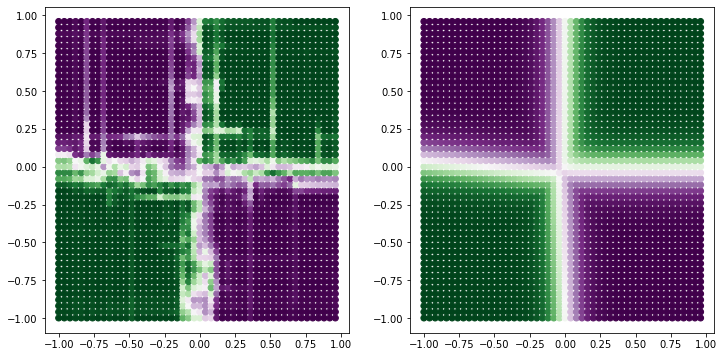

In [14]:
fig, ax = plt.subplots(1,2, figsize=(6*2,6))
ax[0].scatter(grid[:,0], grid[:,1], c=pred_rf[:,1], cmap='PRGn')
ax[1].scatter(grid[:,0], grid[:,1], c=pred_mlp[:,1], cmap='PRGn')

## Create synthetic polytope regions

#### Create reference points for polytope

In [15]:
# random.choice(grid)
choice = random.choices(grid,k=64)
choice = np.array(choice)
choice.shape

(64, 2)

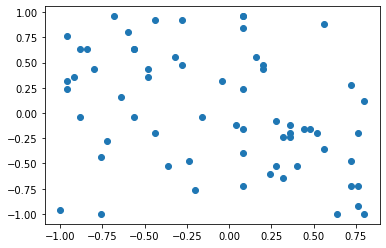

In [16]:
plt.scatter(choice[:,0], choice[:,1])

#### Create N polytopes using voronoi algorithm

In [17]:
vr = Voronoi(choice)

#### Plot polytope backbone

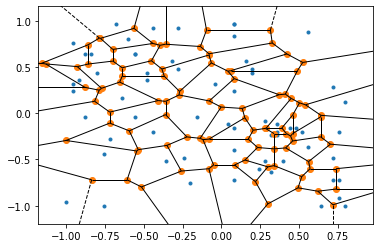

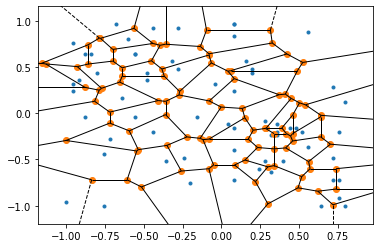

In [18]:
voronoi_plot_2d(vr)

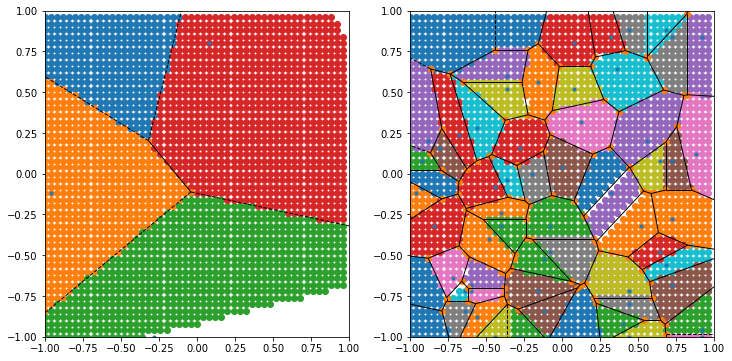

In [19]:
fig, ax = plt.subplots(1,2, figsize=(6*2,6))

for ix, k in enumerate([4, 64]):

    random.seed(seed)

    choice = random.choices(grid, k=k)
    choice = np.array(choice)

    vr = Voronoi(choice[:,:2])

    polytope_points = []

    regions, vertices = voronoi_finite_polygons_2d(vr)

    for region in regions:
        poly = [vertices[i] for i in region]
        p = Path(poly)
        vrt = grid[p.contains_points(grid[:,:2])]
        polytope_points.append(vrt)

    for coor in polytope_points:
        ax[ix].scatter(coor[:,0],coor[:,1])

    voronoi_plot_2d(vr, ax=ax[ix])

    ax[ix].set_xlim(-1,1)
    ax[ix].set_ylim(-1,1)

## Polytope Experiment

#### Create N polytopes using training data

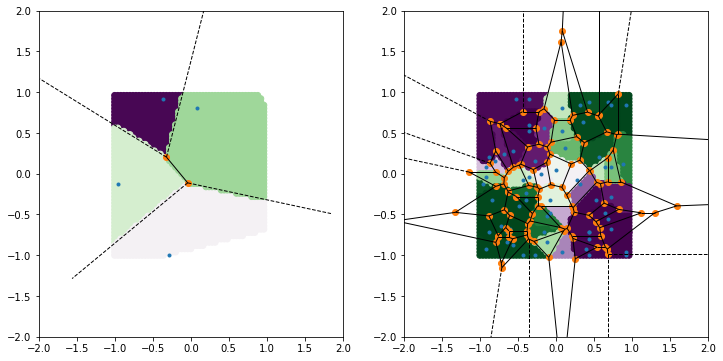

In [20]:
polytope_points = generate_polytope(rng=rng, h=h, label=pred_rf[:,1].reshape(-1,1), grid=grid, seed=seed)

#### Experiment to calculate mean error using true posterior

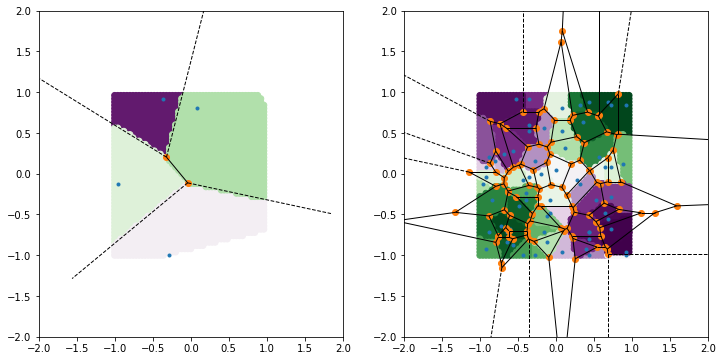

In [21]:
tp = trueXOR_old #alias

polytope_points_true = generate_polytope(rng=rng, h=h, label=tp[2].reshape(-1,1), grid=grid, seed=seed)

In [22]:
np.mean(abs(np.array([i[0][2] for i in polytope_points]) - np.array([i[0][2] for i in polytope_points_true])))

0.019984909374118204

#### Experiment to calculate the risk
The definition of the risk here is the expected mis-classification error.
The test simulation of the given XOR dataset is used to calculated the mis-classification error. The averaged posterior within each polytope of the prediction computed from training data is subsequently converted into a class. The risk based on whether each point from test data is correctly reside within the polytope is calculated here.

- Get class 1 posterior from training data
- Change each polytope, where they're initially the average of class 1 probability, into a class
- Match test data to the polytope generated by the training data
- Compute the expected mis-classification error
- Do this for [RF, DN] with [XOR, RXOR, NXOR] over different sample size between [4, 64] polytopes

In [23]:
#create test data
X, y = generate_gaussian_parity(n_samples=N)
X = np.append(X,y.reshape(-1,1),axis=1)

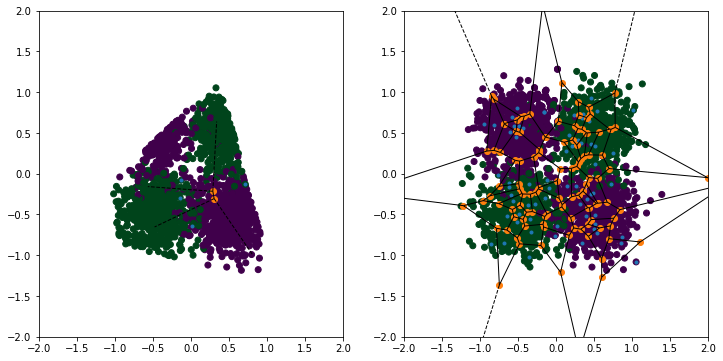

In [24]:
polytope_points_test = generate_polytope(rng=rng, h=h, grid=X, seed=seed, no_plot=True)

In [25]:
pA = polytope_points
pB = polytope_points_test

polylist = [4,64]
risks = [[] for _ in range(len(polylist))]
cnts = [[] for _ in range(len(polylist))]

for ix, k in enumerate(polylist):

    risk = 0
    cnt = 0

    for pp, pp_test in zip(pA[ix], pB[ix]):
        for ppt in pp_test:
            cnt += 1
            print(cnt, np.argmax([0.5, pp[0][2]]), int(ppt[2]), int(np.argmax([0.5, pp[0][2]]) != int(ppt[2])))
            risk += int(np.argmax([0.5, pp[0][2]]) != int(ppt[2]))

    cnts[ix] = cnt
    risks[ix] = risk

1 0 1 1
2 0 1 1
3 0 1 1
4 0 1 1
5 0 1 1
6 0 1 1
7 0 1 1
8 0 1 1
9 0 1 1
10 0 1 1
11 0 1 1
12 0 1 1
13 0 1 1
14 0 1 1
15 0 1 1
16 0 1 1
17 0 1 1
18 0 1 1
19 0 1 1
20 0 1 1
21 0 1 1
22 0 1 1
23 0 1 1
24 0 1 1
25 0 1 1
26 0 0 0
27 0 1 1
28 0 1 1
29 0 1 1
30 0 1 1
31 0 1 1
32 0 1 1
33 0 1 1
34 0 1 1
35 0 1 1
36 0 1 1
37 0 1 1
38 0 1 1
39 0 1 1
40 0 1 1
41 0 1 1
42 0 1 1
43 0 1 1
44 0 1 1
45 0 1 1
46 0 1 1
47 0 1 1
48 0 1 1
49 0 1 1
50 0 1 1
51 0 0 0
52 0 1 1
53 0 1 1
54 0 1 1
55 0 1 1
56 0 1 1
57 0 0 0
58 0 1 1
59 0 1 1
60 0 1 1
61 0 1 1
62 0 1 1
63 0 0 0
64 0 1 1
65 0 1 1
66 0 1 1
67 0 1 1
68 0 1 1
69 0 1 1
70 0 1 1
71 0 1 1
72 0 1 1
73 0 1 1
74 0 1 1
75 0 1 1
76 0 1 1
77 0 1 1
78 0 1 1
79 0 1 1
80 0 1 1
81 0 1 1
82 0 1 1
83 0 1 1
84 0 1 1
85 0 1 1
86 0 1 1
87 0 1 1
88 0 1 1
89 0 1 1
90 0 1 1
91 0 1 1
92 0 1 1
93 0 1 1
94 0 1 1
95 0 1 1
96 0 1 1
97 0 1 1
98 0 1 1
99 0 1 1
100 0 1 1
101 0 1 1
102 0 1 1
103 0 1 1
104 0 1 1
105 0 1 1
106 0 0 0
107 0 1 1
108 0 1 1
109 0 1 1
110 0 1 1
111 0 1 

In [26]:
X.shape, cnts, risks, len(pA[0][0])

((2500, 3), [1722, 2563], [1023, 1420], 304)

In [30]:
for i,j in zip(risks, cnts):
    print(i/j)

0.5940766550522648
0.5540382364416699
